 ## pipeline

In [1]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import semantic_segment_crop_and_cat_3_channel_output_edge_gated_model, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_edge_gated_X
from func.ultis import save_obj, load_obj

# graph import stuff
from func.graph_learning import SuperVoxToNxGraph, VoxelGraphDataset, Cluster_Super_Vox_Graph, segment_super_vox_3_channel_graph_learning_edge_gated_model
from func.graph_models import GCN

Using backend: pytorch


### init model

In [2]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=""
model=CellSegNet_basic_edge_gated_X(input_channel=1, n_classes=3, output_func = "softmax")
load_path='output/model_HMS_edge_gated_24_1.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# load graph model
graph_model = GCN(3, num_classes=1)
checkpoint_graph = 'output/graph_model_focal_edge_gated.pt'
graph_model.load_state_dict(torch.load(checkpoint_graph))
graph_model.eval()

#summary(model, (1, 64, 64, 64))

GCN(
  (conv1): GraphConv(in=3, out=16, normalization=both, activation=None)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): GraphConv(in=16, out=1, normalization=both, activation=None)
)

### dataset info

In [3]:
HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

### seg one img

parameter setting

In [4]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=64
stride=32

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [5]:
print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "120"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]).astype(float)
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Test cases: dict_keys(['135', '120', '65', '90'])
for test case 120 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/120.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/120/120_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/120/120_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/120/120_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/120/120_ins.npy'}


feed raw image crops to the model

In [6]:
start = time.time()

# feed the raw img to the model
print('Feed raw img to model')
raw_img_size=raw_img.shape
    
seg_background_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img=\
        semantic_segment_crop_and_cat_3_channel_output_edge_gated_model(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_background_comp+=seg_background
    seg_boundary_comp+=seg_boundary
#print("Get model semantic seg by combination")
seg_background_comp = np.array(seg_background_comp>0, dtype=float)
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=float)
seg_foreground_comp = np.array(1 - seg_background_comp - seg_boundary_comp>0, dtype=float)

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model
1: Transpose the image to be: [0, 1, 2]


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


s of segment_3d_img: 99%Time elapsed:  482.2196259498596


6

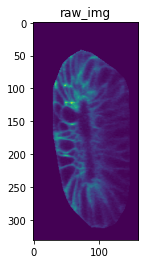

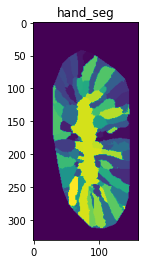

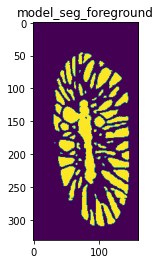

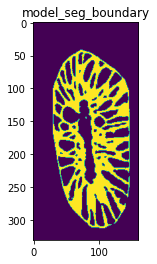

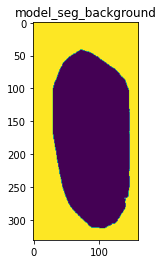

In [7]:
# show current result

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[N,:,:]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[N,:,:])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[N,:,:])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[N,:,:])

TASCAN

generate super vox by watershed

In [8]:
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

In [9]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 1745 super voxels


super voxel clustearing

In [10]:
# cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
# cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
# seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

# import pickle
# pickle.dump(seg_foreground_super_voxel_by_ws, open("test_seg_foreground_super_voxel_by_ws.pkl", "wb" ))

In [11]:
cluster_super_vox=Cluster_Super_Vox_Graph(graph_model)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws, fake_predictions=False)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img



getting neighbor pairs
adding neighbor ids
calculate edges
build networkx graph


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  return th.as_tensor(data, dtype=dtype)


predict...
using prediction for single-output model
number of negatives: 5
everything predicted!


delete too small cells

In [12]:
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [13]:
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

see the final result

In [14]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [15]:
seg_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

31659388646288210.336244541484716160.35589519650655020.375545851528384270.39519650655021830.41484716157205240.43449781659388650.454148471615720530.47379912663755460.493449781659388630.51310043668122270.53275109170305680.55240174672489080.57205240174672490.59170305676855890.6113537117903930.6310043668122270.65065502183406110.67030567685589510.68995633187772930.70960698689956340.72925764192139740.74890829694323150.76855895196506550.78820960698689960.80786026200873360.82751091703056770.84716157205240170.86681222707423580.88646288209606980.90611353711790390.9257641921397380.94541484716157210.96506550218340610.98471615720524020.00.0221130221130221120.041769041769041770.061425061425061430.081081081081081090.100737100737100740.120393120393120390.140049140049140040.15970515970515970.179361179361179370.199017199017199030.218673218673218680.238329238329238330.2579852579852580.277641277641277660.29729729729729730.316953316953316970.33660933660933660.356265356265356270.37592137592137590.3955773955

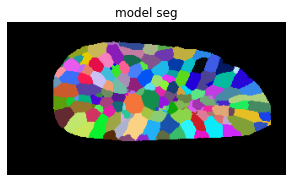

In [16]:
N=100
fig = plt.figure(figsize=(5,5))
plt.title("model seg")
plt.axis('off')
plt.imshow(seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

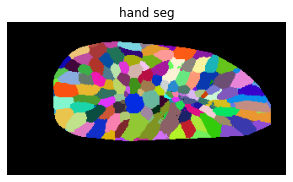

In [17]:
fig = plt.figure(figsize=(5,5))
plt.title("hand seg")
plt.axis('off')
plt.imshow(hand_seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

In [18]:
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")

calculate accuracy

In [19]:
ARI = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg.astype(int).flatten(), seg_final.astype(int).flatten())
VOI_val = VOI(seg_final.astype(int),hand_seg.astype(int))

In [20]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.9916864510970086
ARE: (0.3969286023917741, 0.5711719829468057, 0.6387446836496667)
VOI: (1.2885656853099143, 1.0167164033533256)


In [21]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.5
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(181, 331, 160) --> (90, 165, 80)


45

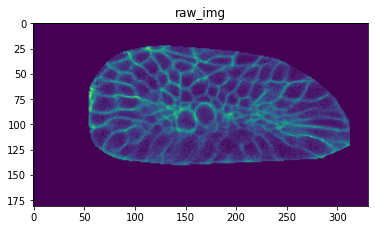

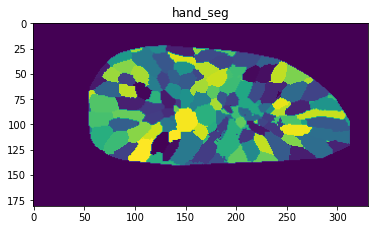

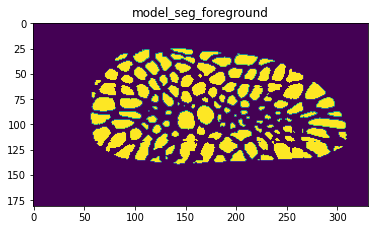

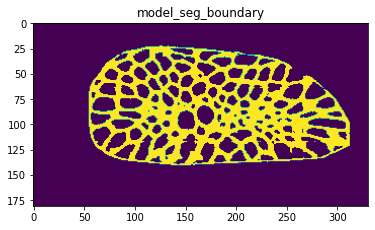

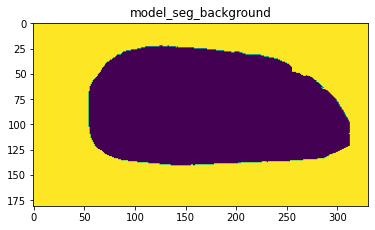

In [22]:
# plot stuff

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[:,:,N])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[:,:,N])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[:,:,N])

.373362445414847140.39301310043668120.41266375545851530.432314410480349350.45196506550218340.471615720524017460.49126637554585150.51091703056768560.53056768558951960.55021834061135370.56986899563318780.58951965065502190.60917030567685590.628820960698690.6484716157205240.6659388646288210.68558951965065510.70524017467248910.72489082969432320.74454148471615720.76419213973799130.78602620087336240.80786026200873360.82969432314410490.84934497816593890.871179039301310.89301310043668130.91484716157205240.93449781659388640.95633187772925770.97598253275109170.9956331877729258

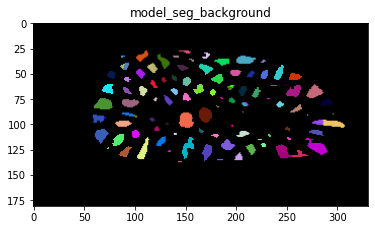

In [23]:
plt.figure()
plt.title("model_seg_background")
plt.imshow(colorful_seg(seg_foreground_super_voxel_by_ws)[:,:,N])

.262008733624454150.28165938864628820.30349344978165940.325327510917030550.344978165938864660.36462882096069870.38646288209606990.408296943231441060.42794759825327510.44978165938864630.469432314410480330.48908296943231440.51091703056768560.53275109170305680.55458515283842790.5742358078602620.59606986899563320.61572052401746720.63537117903930130.65720524017467250.67685589519650660.69650655021834060.71615720524017470.73580786026200870.757641921397380.77947598253275110.79912663755458510.82096069868995640.84279475982532750.86462882096069870.88646288209606980.90829694323144110.93013100436681220.95196506550218340.97161572052401750.9934497816593887

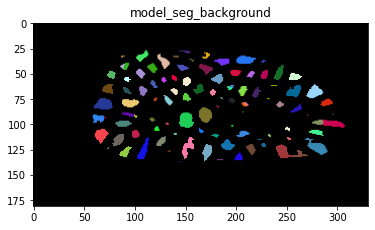

In [24]:
plt.figure()
plt.title("model_seg_background")
plt.imshow(colorful_seg(seg_foreground_single_cell_with_boundary_delete_too_small)[:,:,N])

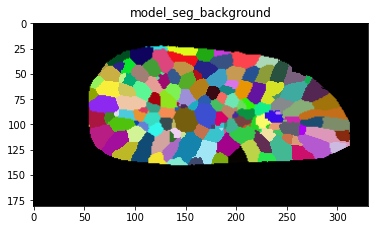

In [25]:
plt.figure()
plt.title("model_seg_background")
plt.imshow(colorful_seg(seg_final)[:,:,N])

In [26]:
supervoxels_image = colorful_seg(seg_foreground_super_voxel_by_ws)
final_seg_image = colorful_seg(seg_final)

187772925764192130.211790393013100430.235807860262008730.2598253275109170.28384279475982530.30786026200873360.327510917030567670.351528384279475970.373362445414847140.39519650655021830.41703056768558950.43668122270742360.45851528384279480.480349344978165950.50218340611353710.52183406113537120.5371179039301310.55021834061135370.56331877729257640.57860262008733620.59606986899563320.61790393013100440.63755458515283850.65720524017467250.67903930131004360.69868995633187770.72052401746724890.742358078602620.76419213973799130.78384279475982530.80349344978165940.82314410480349340.84716157205240170.871179039301310.89301310043668130.91266375545851530.93668122270742360.96069868995633190.9803493449781660.00.0240174672489082970.0480349344978165950.072052401746724890.096069868995633190.120087336244541490.141921397379912660.163755458515283840.187772925764192130.211790393013100430.235807860262008730.2598253275109170.28384279475982530.30786026200873360.33187772925764190.35589519650655020.37991266375545

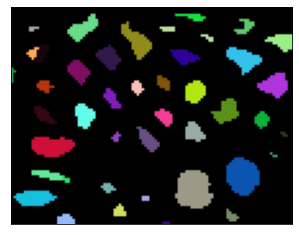

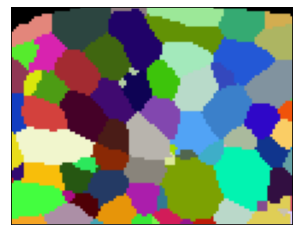

In [39]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(supervoxels_image[25:110,80:190,N])
plt.savefig("figs/architecture_supervoxels.png")

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(final_seg_image[25:110,80:190,N])
plt.savefig("figs/architecture_final_seg.png")

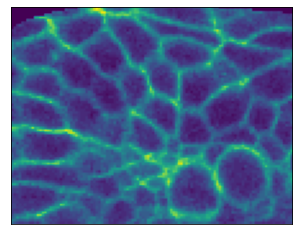

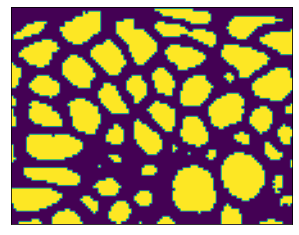

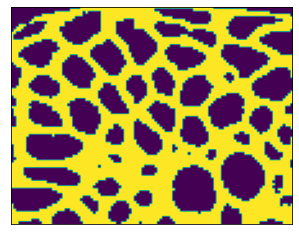

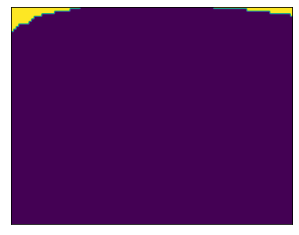

In [38]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(raw_img[25:110,80:190,N])
plt.savefig("figs/architecture_raw_img.png")
#plt.figure()
#plt.title("hand_seg")
#plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(seg_foreground_comp[25:110,80:190,N])
plt.savefig("figs/architecture_foreground_pred.png")

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(seg_boundary_comp[25:110,80:190,N])
plt.savefig("figs/architecture_boundary_pred.png")

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(seg_background_comp[25:110,80:190,N])
plt.savefig("figs/architecture_background_pred.png")